<a href="https://colab.research.google.com/github/Mj2603/Patient-Selection-for-Diabetes-Drug-Testing/blob/main/Selection_of_patient_for_Diabetes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [63]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
from utils import build_vocab_files, show_group_stats_viz, aggregate_dataset, preprocess_df, df_to_dataset, posterior_mean_field, prior_trainable

In [3]:
!pip install aequitas==0.42.0 ;
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import pandas as pd
import aequitas as ae
import seaborn as sns

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [50]:
pd.set_option('display.max_columns', 500)
# this allows us to make changes and save in my_utils.py and the file is reloaded every time you run a code block
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Dataset Loading and Schema Review
Load the dataset and view a sample of the dataset along with reviewing the schema reference files to gain a deeper understanding of the dataset. The dataset is located at the following path . 

Also, review the information found in the data schema 

In [7]:
dataset_path = "/content/final_project_dataset.csv"
df = pd.read_csv(dataset_path)

# Determine Level of Dataset (Line or Encounter)

In [8]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,250.83,?|?,0,0,0,41,1,1,0,NaN,None,None,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,276,250.01|255,0,0,0,59,9,18,0,68071-1701,None,None,Ch,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,648,250|V27,2,1,0,11,6,13,5,0378-1110,None,None,No,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,8,250.43|403,0,0,0,44,7,16,1,68071-1701,None,None,Ch,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Ch,NO


In [9]:
df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'primary_diagnosis_code', 'other_diagnosis_codes', 'number_outpatient',
       'number_inpatient', 'number_emergency', 'num_lab_procedures',
       'number_diagnoses', 'num_medications', 'num_procedures', 'ndc_code',
       'max_glu_serum', 'A1Cresult', 'change', 'readmitted'],
      dtype='object')

In [10]:
df.encounter_id.nunique()

101766

In [11]:
df.patient_nbr.nunique()

71518

In [12]:
df.shape[0]

143424

# Analyze Dataset
Question 2: Utilizing the library of your choice (recommend Pandas and Seaborn or matplotlib though) we address the following questions:
- a. Field(s) with high amount of missing/zero values only ndc_code column has missing values

- b. Based off the frequency histogram for each numerical field, which numerical field(s) has/have a Gaussian(normal) distribution shape?
None off the numerical field has pure normal distribution, but `num_lab_procedures` has some extent of normal distribution which violets at some point.

- c. Which field(s) have high cardinality and why (HINT: ndc_code is one feature)
other_diagnosis_codes, primary_diagnosis_code and ndc_code has high cardinalities. It has different codes related to dieases identified. So, it has more variation.

- d. Please describe the demographic distributions in the dataset for the age and gender fields.
From data, it shown that there are slightly more females than male who are hospitalized and it is more affected in age 60-90.

In [13]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
encounter_id,143424.0,1.674290e+08,1.019046e+08,12522.0,88295964.0,154763706.0,232089688.5,443867222.0
patient_nbr,143424.0,5.493608e+07,3.857840e+07,135.0,23572188.0,46307830.5,88236270.0,189502619.0
admission_type_id,143424.0,2.027694e+00,1.427585e+00,1.0,1.0,1.0,3.0,8.0
discharge_disposition_id,143424.0,3.655316e+00,5.219279e+00,1.0,1.0,1.0,3.0,28.0
admission_source_id,143424.0,5.701096e+00,4.064532e+00,1.0,1.0,7.0,7.0,25.0
time_in_hospital,143424.0,4.490190e+00,2.999667e+00,1.0,2.0,4.0,6.0,14.0
number_outpatient,143424.0,3.624289e-01,1.249295e+00,0.0,0.0,0.0,0.0,42.0
number_inpatient,143424.0,6.008548e-01,1.207934e+00,0.0,0.0,0.0,1.0,21.0
number_emergency,143424.0,1.950859e-01,9.204102e-01,0.0,0.0,0.0,0.0,76.0
num_lab_procedures,143424.0,4.325575e+01,1.965732e+01,1.0,32.0,44.0,57.0,132.0


In [14]:
df.count()

encounter_id                143424
patient_nbr                 143424
race                        143424
gender                      143424
age                         143424
weight                      143424
admission_type_id           143424
discharge_disposition_id    143424
admission_source_id         143424
time_in_hospital            143424
payer_code                  143424
medical_specialty           143424
primary_diagnosis_code      143424
other_diagnosis_codes       143424
number_outpatient           143424
number_inpatient            143424
number_emergency            143424
num_lab_procedures          143424
number_diagnoses            143424
num_medications             143424
num_procedures              143424
ndc_code                    119962
max_glu_serum               143424
A1Cresult                   143424
change                      143424
readmitted                  143424
dtype: int64

In [15]:
numeric_field = [c for c in df.columns if df[c].dtype == "int64"]
numeric_field

['encounter_id',
 'patient_nbr',
 'admission_type_id',
 'discharge_disposition_id',
 'admission_source_id',
 'time_in_hospital',
 'number_outpatient',
 'number_inpatient',
 'number_emergency',
 'num_lab_procedures',
 'number_diagnoses',
 'num_medications',
 'num_procedures']

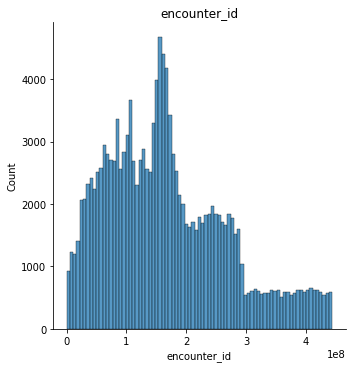

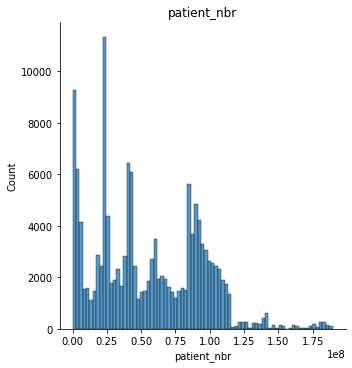

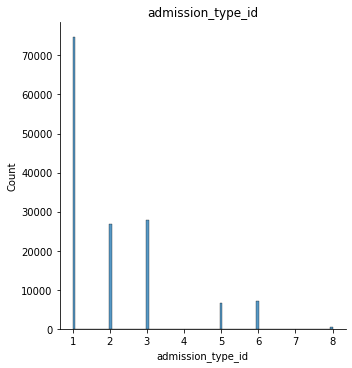

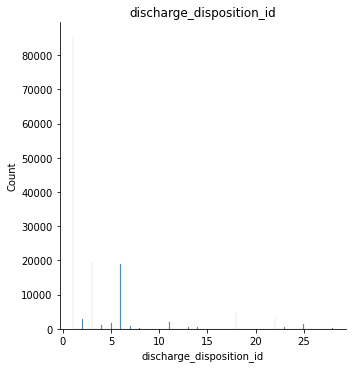

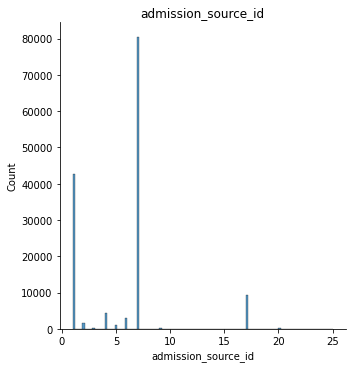

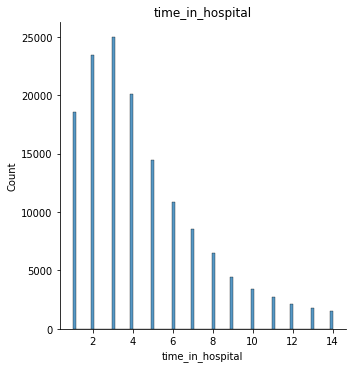

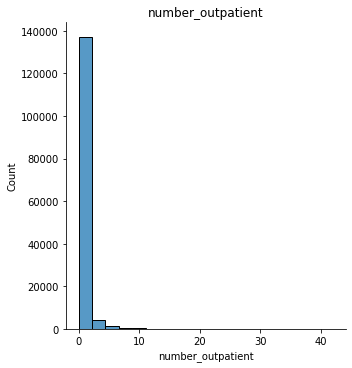

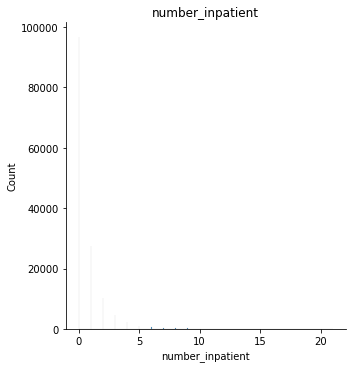

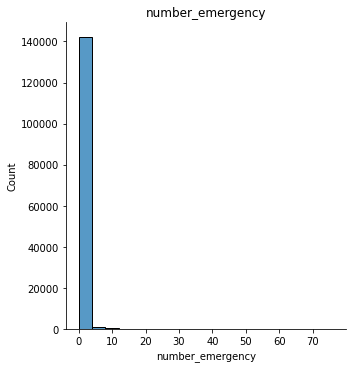

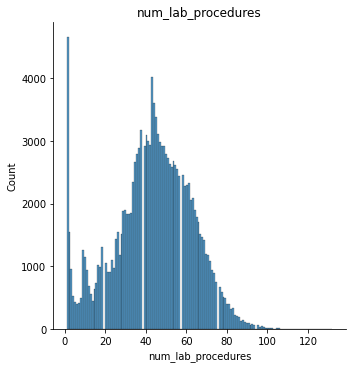

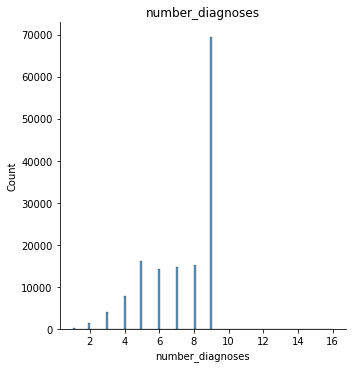

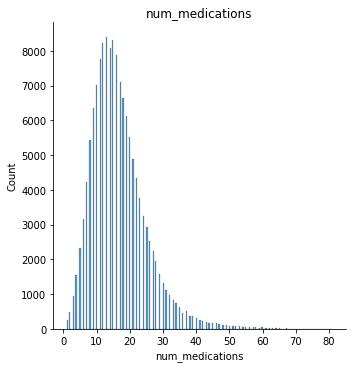

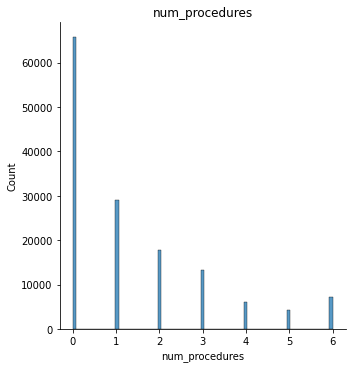

In [17]:
for c in numeric_field:
    sns.displot(df[c], kde=False)
    plt.title(c)
    plt.show()

<Axes: >

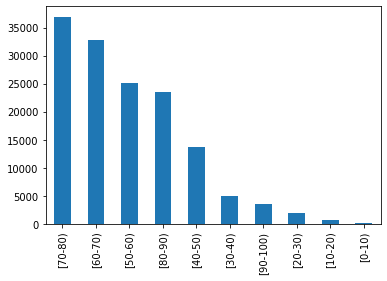

In [18]:
df.age.value_counts().plot(kind='bar')

In [19]:
df.gender.unique()

array(['Female', 'Male', 'Unknown/Invalid'], dtype=object)

<Axes: >

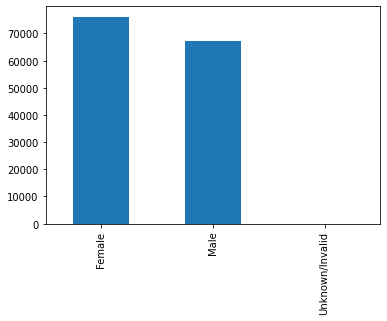

In [20]:
df.gender.value_counts().plot(kind="bar")

In [21]:
pd.DataFrame({'cardinality': df.nunique() } )

,cardinality
encounter_id,101766
patient_nbr,71518
race,6
gender,3
age,10
weight,10
admission_type_id,8
discharge_disposition_id,26
admission_source_id,17
time_in_hospital,14


# Reduce Dimensionality of the NDC Code Feature

NDC codes are a common format to represent the wide variety of drugs that are prescribed for patient care in the United States. The challenge is that there are many codes that map to the same or similar drug. We are provided with the ndc drug lookup file  derived from the National Drug Codes List site(https://ndclist.com/). We use this file to come up with a way to reduce the dimensionality of this field and create a new field in the dataset called "generic_drug_name" in the output dataframe.

In [22]:
#NDC code lookup file
ndc_code_path = "/content/final_ndc_lookup_table"
ndc_code_df = pd.read_csv(ndc_code_path)

In [23]:
from student_utils import reduce_dimension_ndc

In [25]:
df.ndc_code

0                NaN
1         68071-1701
2          0378-1110
3         68071-1701
4          0049-4110
             ...    
143419     47918-902
143420     0049-4110
143421     0781-5421
143422     47918-902
143423           NaN
Name: ndc_code, Length: 143424, dtype: object

In [26]:
ndc_code_df.head()

,NDC_Code,Proprietary Name,Non-proprietary Name,Dosage Form,Route Name,Company Name,Product Type
0,0087-6060,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug
1,0087-6063,Glucophage XR,Metformin Hydrochloride,"Tablet, Extended Release",Oral,Bristol-myers Squibb Company,Human Prescription Drug
2,0087-6064,Glucophage XR,Metformin Hydrochloride,"Tablet, Extended Release",Oral,Bristol-myers Squibb Company,Human Prescription Drug
3,0087-6070,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug
4,0087-6071,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug


In [27]:
ndc_code_df

,NDC_Code,Proprietary Name,Non-proprietary Name,Dosage Form,Route Name,Company Name,Product Type
0,0087-6060,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug
1,0087-6063,Glucophage XR,Metformin Hydrochloride,"Tablet, Extended Release",Oral,Bristol-myers Squibb Company,Human Prescription Drug
2,0087-6064,Glucophage XR,Metformin Hydrochloride,"Tablet, Extended Release",Oral,Bristol-myers Squibb Company,Human Prescription Drug
3,0087-6070,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug
4,0087-6071,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug
...,...,...,...,...,...,...,...
264,0781-5635,Pioglitazone Hydrochloride And Glimepiride,Pioglitazone Hydrochloride And Glimepiride,Tablet,Oral,Sandoz Inc,Human Prescription Drug
265,64764-302,Duetact,Pioglitazone And Glimepiride,Tablet,Oral,"Takeda Pharmaceuticals America, Inc.",Human Prescription Drug
266,64764-304,Duetact,Pioglitazone And Glimepiride,Tablet,Oral,"Takeda Pharmaceuticals America, Inc.",Human Prescription Drug
267,66993-821,Pioglitazone And Glimepiride,Pioglitazone And Glimepiride,Tablet,Oral,Prasco Laboratories,Human Prescription Drug


In [28]:
reduce_dim_df = reduce_dimension_ndc(df, ndc_code_df)
reduce_dim_df

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted,NDC_Code,generic_drug_name
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,250.83,?|?,0,0,0,41,1,1,0,NaN,None,None,No,NO,NaN,NaN
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,276,250.01|255,0,0,0,59,9,18,0,68071-1701,None,None,Ch,>30,68071-1701,Human Insulin
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,648,250|V27,2,1,0,11,6,13,5,0378-1110,None,None,No,NO,0378-1110,Glipizide
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,8,250.43|403,0,0,0,44,7,16,1,68071-1701,None,None,Ch,NO,68071-1701,Human Insulin
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Ch,NO,0049-4110,Glipizide
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143477,443854148,41088789,Caucasian,Male,[70-80),?,1,1,7,1,MC,?,38,590|296,1,0,0,53,13,9,0,47918-902,None,None,Ch,NO,47918-902,Insulin Human
143478,443857166,31693671,Caucasian,Female,[80-90),?,2,3,7,10,MC,Surgery-General,996,285|998,0,1,0,45,9,21,2,0049-4110,None,None,Ch,NO,0049-4110,Glipizide
143479,443857166,31693671,Caucasian,Female,[80-90),?,2,3,7,10,MC,Surgery-General,996,285|998,0,1,0,45,9,21,2,0781-5421,None,None,Ch,NO,0781-5421,Pioglitazone
143480,443857166,31693671,Caucasian,Female,[80-90),?,2,3,7,10,MC,Surgery-General,996,285|998,0,1,0,45,9,21,2,47918-902,None,None,Ch,NO,47918-902,Insulin Human


In [29]:
# Number of unique values should be less for the new output field
assert df['ndc_code'].nunique() > reduce_dim_df['generic_drug_name'].nunique()

# Select First Encounter for each Patient
In order to simplify the aggregation of data for the model, we will only select the first encounter for each patient in the dataset. This is to reduce the risk of data leakage of future patient encounters and to reduce complexity of the data transformation and modeling steps. We will assume that sorting in numerical order on the encounter_id provides the time horizon for determining which encounters come before and after another.

In [30]:
from student_utils import select_first_encounter
first_encounter_df = select_first_encounter(reduce_dim_df)

In [31]:
# unique patients in transformed dataset
unique_patients = first_encounter_df['patient_nbr'].nunique()
print("Number of unique patients:{}".format(unique_patients))

# unique encounters in transformed dataset
unique_encounters = first_encounter_df['encounter_id'].nunique()
print("Number of unique encounters:{}".format(unique_encounters))

original_unique_patient_number = reduce_dim_df['patient_nbr'].nunique()
# number of unique patients should be equal to the number of unique encounters and patients in the final dataset
assert original_unique_patient_number == unique_patients
assert original_unique_patient_number == unique_encounters
print("Tests passed!!")

Number of unique patients:71518
Number of unique encounters:71518
Tests passed!!


# Aggregate Dataset to Right Level for Modeling

We are creating dummy columns for each unique generic drug name and adding those are input features to the model. There are other options for data representation,

In [32]:
exclusion_list = ['generic_drug_name']
grouping_field_list = [c for c in first_encounter_df.columns if c not in exclusion_list]
agg_drug_df, ndc_col_list = aggregate_dataset(first_encounter_df, grouping_field_list, 'generic_drug_name')

/content/utils.py:9: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df = df.groupby(grouping_field_list)['encounter_id',
/content/utils.py:13: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  dummy_df = pd.get_dummies(df[array_field + '_array'].apply(pd.Series).stack()).sum(level=0)


In [33]:
len(grouping_field_list)

27

In [34]:
agg_drug_df['patient_nbr'].nunique()

54271

In [35]:
agg_drug_df['encounter_id'].nunique()

54271

In [36]:
len(agg_drug_df)

54271

In [37]:
assert len(agg_drug_df) == agg_drug_df['patient_nbr'].nunique() == agg_drug_df['encounter_id'].nunique()

#Prepare Fields and Cast Dataset
##Feature Selection

In [38]:
df.weight.value_counts()

?            139122
[75-100)       1817
[50-75)        1133
[100-125)       890
[125-150)       200
[25-50)         118
[0-25)           67
[150-175)        55
[175-200)        18
>200              4
Name: weight, dtype: int64

In [39]:
df.payer_code.value_counts()

?     54190
MC    46532
HM     8784
SP     7613
BC     6991
MD     4983
CP     3687
UN     3665
CM     2971
OG     1532
PO      919
DM      757
WC      230
CH      208
OT      160
MP      122
SI       79
FR        1
Name: payer_code, dtype: int64

In [40]:
df.medical_specialty.value_counts()

?                                   69463
InternalMedicine                    20403
Emergency/Trauma                    11595
Family/GeneralPractice              10508
Cardiology                           7473
                                    ...  
Speech                                  1
Proctology                              1
Perinatology                            1
Pediatrics-InfectiousDiseases           1
Surgery-PlasticwithinHeadandNeck        1
Name: medical_specialty, Length: 73, dtype: int64

From cells above, weight field has 139122 missing values. It's fine if we exclude in model training. For payer_code, it also has 54190 missing value and it not much affect on our training process just beacause it will not help to identify time_in_hospital.

In [41]:
numeric_field

['encounter_id',
 'patient_nbr',
 'admission_type_id',
 'discharge_disposition_id',
 'admission_source_id',
 'time_in_hospital',
 'number_outpatient',
 'number_inpatient',
 'number_emergency',
 'num_lab_procedures',
 'number_diagnoses',
 'num_medications',
 'num_procedures']

In [42]:
categorical_field = df.columns.drop(numeric_field)
categorical_field

Index(['race', 'gender', 'age', 'weight', 'payer_code', 'medical_specialty',
       'primary_diagnosis_code', 'other_diagnosis_codes', 'ndc_code',
       'max_glu_serum', 'A1Cresult', 'change', 'readmitted'],
      dtype='object')

In [43]:
required_demo_col_list = ['race', 'gender', 'age']

student_categorical_col_list = [ "ndc_code", "readmitted", 'admission_type_id', 'discharge_disposition_id',
                                'max_glu_serum', 'admission_source_id', 'A1Cresult', 'primary_diagnosis_code',
                                'other_diagnosis_codes', 'change'] + required_demo_col_list + ndc_col_list

student_numerical_col_list = [ "num_procedures", "num_medications", 'number_diagnoses']

PREDICTOR_FIELD = 'time_in_hospital'

In [44]:
def select_model_features(df, categorical_col_list, numerical_col_list, PREDICTOR_FIELD, grouping_key='patient_nbr'):
    selected_col_list = [grouping_key] + [PREDICTOR_FIELD] + categorical_col_list + numerical_col_list   
    return agg_drug_df[selected_col_list]

In [45]:
selected_features_df = select_model_features(agg_drug_df, student_categorical_col_list, student_numerical_col_list,
                                            PREDICTOR_FIELD)

# Preprocess Dataset - Casting and Imputing
We will cast and impute the dataset before splitting so that we do not have to repeat these steps across the splits in the next step. For imputing, there can be deeper analysis into which features to impute and how to impute but we are taking a general strategy of imputing zero for only numerical features.

In [46]:
processed_df = preprocess_df(selected_features_df, student_categorical_col_list, 
        student_numerical_col_list, PREDICTOR_FIELD, categorical_impute_value='nan', numerical_impute_value=0)

/content/utils.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[predictor] = df[predictor].astype(float)
/content/utils.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[c] = cast_df(df, c, d_type=str)
/content/utils.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

# Split Dataset into Train, Validation, and Test Partitions

We split the input dataset into three partitions(train, validation, test) with the following requirements.
*   Approximately 60%/20%/20% train/validation/test split
*   Randomly sample different patients into each data partition
*   Total number of unique patients across the splits is equal to the total number of unique patients in the original dataset
*   Total number of rows in original dataset = sum of rows across all three dataset partitions

In [47]:
processed_df = pd.DataFrame(processed_df)
processed_df


,patient_nbr,time_in_hospital,ndc_code,readmitted,admission_type_id,discharge_disposition_id,max_glu_serum,admission_source_id,A1Cresult,primary_diagnosis_code,other_diagnosis_codes,change,race,gender,age,Acarbose,Glimepiride,Glipizide,Glipizide_And_Metformin_Hcl,Glipizide_And_Metformin_Hydrochloride,Glyburide,Glyburide_And_Metformin_Hydrochloride,Glyburide-metformin_Hydrochloride,Human_Insulin,Insulin_Human,Metformin_Hcl,Metformin_Hydrochloride,Miglitol,Nateglinide,Pioglitazone,Pioglitazone_Hydrochloride_And_Glimepiride,Repaglinide,Rosiglitazone_Maleate,Tolazamide,Tolbutamide,num_procedures,num_medications,number_diagnoses
0,48330783,13.0,47918-902,NO,2,1,None,4,None,398,427|38,Ch,Caucasian,Female,[80-90),0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,28,8
1,63555939,12.0,68071-1701,NO,3,3,None,4,None,434,198|486,Ch,Caucasian,Female,[90-100),0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,3,18,8
2,42519267,1.0,0049-4110,NO,1,1,None,7,None,197,157|250,Ch,Caucasian,Male,[40-50),0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,5
3,89869032,9.0,68071-1701,>30,1,1,None,7,None,250.7,403|996,No,AfricanAmerican,Female,[40-50),0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,17,9
4,82637451,3.0,47918-902,>30,2,1,None,2,None,414,411|250,No,Caucasian,Male,[50-60),0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,16,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54266,184875899,13.0,0904-6328,NO,1,1,None,7,None,250.8,730|731,Ch,Other,Male,[40-50),0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2,13,9
54267,183087545,9.0,0009-3449,>30,1,1,None,7,>7,574,574|250.02,Ch,Caucasian,Female,[70-80),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,33,9
54268,188574944,14.0,0049-0178,>30,1,1,None,7,>8,592,599|518,Ch,Other,Female,[40-50),0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,26,9
54269,140199494,2.0,47918-902,>30,1,1,None,7,None,996,585|403,No,Other,Female,[60-70),0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,17,9


In [49]:
from my_utils import patient_dataset_splitter
d_train, d_val, d_test = patient_dataset_splitter(processed_df, 'patient_nbr')

In [51]:
assert len(d_train) + len(d_val) + len(d_test) == len(processed_df)
print("Test passed for number of total rows equal!")

Test passed for number of total rows equal!


In [52]:
assert (d_train['patient_nbr'].nunique() + d_val['patient_nbr'].nunique() + d_test['patient_nbr'].nunique()) == agg_drug_df['patient_nbr'].nunique()
print("Test passed for number of unique patients being equal!")

Test passed for number of unique patients being equal!


# Demographic Representation Analysis of Split
After the split, we should check to see the distribution of key features/groups and make sure that there is representative samples across the partitions. The show_group_stats_viz function in the utils.py file can be used to group and visualize different groups and dataframe partitions.

# Label Distribution Across Partitions
Below you can see the distributution of the label across your splits.

time_in_hospital
1.0     7318
2.0     9191
3.0     9740
4.0     7417
5.0     5348
6.0     3991
7.0     3123
8.0     2311
9.0     1597
10.0    1241
11.0    1008
12.0     783
13.0     663
14.0     540
dtype: int64
Axes(0.125,0.125;0.775x0.755)


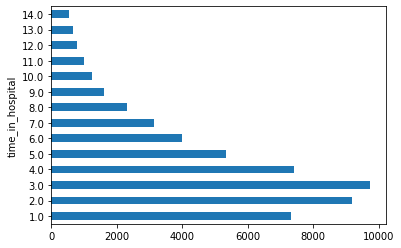

In [54]:
show_group_stats_viz(processed_df, PREDICTOR_FIELD)

time_in_hospital
1.0     4375
2.0     5468
3.0     5879
4.0     4401
5.0     3161
6.0     2372
7.0     1916
8.0     1429
9.0      986
10.0     755
11.0     617
12.0     484
13.0     393
14.0     326
dtype: int64
Axes(0.125,0.125;0.775x0.755)


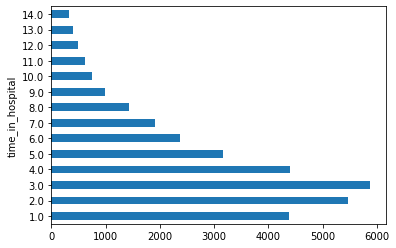

In [55]:
show_group_stats_viz(d_train, PREDICTOR_FIELD)

time_in_hospital
1.0     1429
2.0     1907
3.0     1945
4.0     1536
5.0     1077
6.0      797
7.0      590
8.0      435
9.0      311
10.0     252
11.0     208
12.0     148
13.0     121
14.0      99
dtype: int64
Axes(0.125,0.125;0.775x0.755)


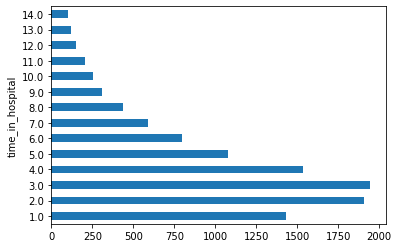

In [56]:
show_group_stats_viz(d_test, PREDICTOR_FIELD)

# Demographic Group Analysis
We should check that our partitions/splits of the dataset are similar in terms of their demographic profiles. Below you can see how we might visualize and analyze the full dataset vs. the partitions.

gender
Female             28572
Male               25697
Unknown/Invalid        2
dtype: int64
Axes(0.125,0.125;0.775x0.755)


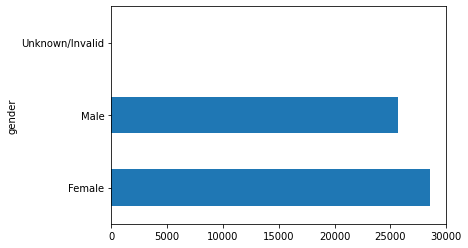

In [57]:
# Full dataset before splitting
patient_demo_features = ['race', 'gender', 'age', 'patient_nbr']
patient_group_analysis_df = processed_df[patient_demo_features].groupby('patient_nbr').head(1).reset_index(drop=True)
show_group_stats_viz(patient_group_analysis_df, 'gender')

gender
Female             17081
Male               15479
Unknown/Invalid        2
dtype: int64
Axes(0.125,0.125;0.775x0.755)


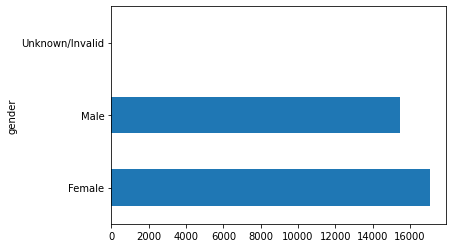

In [58]:
# Training partition
show_group_stats_viz(d_train, 'gender')

gender
Female    5689
Male      5166
dtype: int64
Axes(0.125,0.125;0.775x0.755)


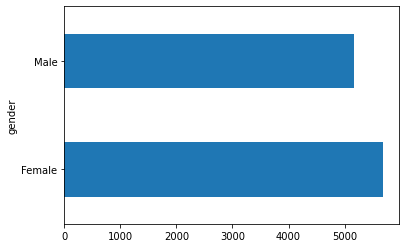

In [59]:
# Test partition
show_group_stats_viz(d_test, 'gender')

#Convert Dataset Splits to TF Dataset
We have provided you the function to convert the Pandas dataframe to TF tensors using the TF Dataset API. Please note that this is not a scalable method and for larger datasets, the 'make_csv_dataset' method is recommended -https://www.tensorflow.org/api_docs/python/tf/data/experimental/make_csv_dataset.

In [60]:
# Convert dataset from Pandas dataframes to TF dataset 
batch_size = 128
diabetes_train_ds = df_to_dataset(d_train, PREDICTOR_FIELD, batch_size=batch_size)
diabetes_val_ds = df_to_dataset(d_val, PREDICTOR_FIELD, batch_size=batch_size)
diabetes_test_ds = df_to_dataset(d_test, PREDICTOR_FIELD, batch_size=batch_size)



In [61]:
# We use this sample of the dataset to show transformations later
diabetes_batch = next(iter(diabetes_train_ds))[0]
def demo(feature_column, example_batch):
    feature_layer = layers.DenseFeatures(feature_column)
    print(feature_layer(example_batch))

# 4. Create Categorical Features with TF Feature Columns
Build Vocabulary for Categorical Features
Before we can create the TF categorical features, we must first create the vocab files with the unique values for a given field that are from the training dataset. Below we have provided a function that you can use that only requires providing the pandas train dataset partition and the list of the categorical columns in a list format. The output variable 'vocab_file_list' will be a list of the file paths that can be used in the next step for creating the categorical features.

In [66]:
vocab_file_list = build_vocab_files(d_train, student_categorical_col_list)

In [68]:
from my_utils import create_tf_categorical_feature_cols
tf_cat_col_list = create_tf_categorical_feature_cols(student_categorical_col_list)

### ndc_code: #lines: 237, embedding (categorical)
### readmitted: #lines: 4, indicator (categorical)
### admission_type_id: #lines: 9, indicator (categorical)
### discharge_disposition_id: #lines: 26, embedding (categorical)
### max_glu_serum: #lines: 5, indicator (categorical)
### admission_source_id: #lines: 18, embedding (categorical)
### A1Cresult: #lines: 5, indicator (categorical)
### primary_diagnosis_code: #lines: 612, embedding (categorical)
### other_diagnosis_codes: #lines: 9495, embedding (categorical)
### change: #lines: 3, indicator (categorical)
### race: #lines: 7, indicator (categorical)
### gender: #lines: 4, indicator (categorical)
### age: #lines: 11, embedding (categorical)
### Acarbose: #lines: 3, indicator (categorical)
### Glimepiride: #lines: 3, indicator (categorical)
### Glipizide: #lines: 3, indicator (categorical)
### Glipizide_And_Metformin_Hcl: #lines: 3, indicator (categorical)
### Glipizide_And_Metformin_Hydrochloride: #lines: 3, indicator (categorical

In [69]:
test_cat_var1 = tf_cat_col_list[0]
print("Example categorical field:\n{}".format(test_cat_var1))
demo(test_cat_var1, diabetes_batch)

Example categorical field:
EmbeddingColumn(categorical_column=VocabularyFileCategoricalColumn(key='ndc_code', vocabulary_file='./diabetes_vocab/ndc_code_vocab.txt', vocabulary_size=237, num_oov_buckets=0, dtype=tf.string, default_value=-1, file_format=None), dimension=10, combiner='mean', initializer=<tensorflow.python.ops.init_ops.TruncatedNormal object at 0x7f90b8b347c0>, ckpt_to_load_from=None, tensor_name_in_ckpt=None, max_norm=None, trainable=True, use_safe_embedding_lookup=True)
tf.Tensor(
[[-0.3027665  -0.08471379 -0.42449534 ... -0.35712373  0.26503253
  -0.12012997]
 [-0.3110195   0.10079824  0.15847503 ... -0.4225161  -0.33382666
  -0.18561684]
 [-0.24633582  0.378652    0.23958102 ...  0.18893398 -0.2869386
   0.5328412 ]
 ...
 [ 0.20052272 -0.5205849  -0.40184554 ...  0.27437115 -0.4246948
  -0.36633372]
 [ 0.41259533 -0.25028688  0.536023   ... -0.15238473 -0.02798279
  -0.33364347]
 [-0.14480443 -0.04756702 -0.09189741 ... -0.39557925 -0.46881473
  -0.53791606]], shape=(1

# Create Numerical Features with TF Feature Columns
Question 8: Using the TF Feature Column API(https://www.tensorflow.org/api_docs/python/tf/feature_column/), we create normalized Tensorflow numeric features for the model. We use the z-score normalizer function below to help as well as the 'calculate_stats_from_train_data' function.

In [70]:
from my_utils import create_tf_numeric_feature

For simplicity the create_tf_numerical_feature_cols function below uses the same normalizer function across all features(z-score normalization) but if you have time feel free to analyze and adapt the normalizer based off the statistical distributions. You may find this as a good resource in determining which transformation fits best for the data https://developers.google.com/machine-learning/data-prep/transform/normalization.





In [71]:
def calculate_stats_from_train_data(df, col):
    mean = df[col].describe()['mean']
    std = df[col].describe()['std']
    return mean, std

def create_tf_numerical_feature_cols(numerical_col_list, train_df):
    tf_numeric_col_list = []
    for c in numerical_col_list:
        mean, std = calculate_stats_from_train_data(train_df, c)
        tf_numeric_feature = create_tf_numeric_feature(c, mean, std)
        tf_numeric_col_list.append(tf_numeric_feature)
    return tf_numeric_col_list

In [72]:
tf_cont_col_list = create_tf_numerical_feature_cols(student_numerical_col_list, d_train)
test_cont_var1 = tf_cont_col_list[0]
print("Example continuous field:\n{}\n".format(test_cont_var1))
demo(test_cont_var1, diabetes_batch)

### num_procedures: #mean/std: 1.4221792273201892/1.7665345724057384, numeric (normalized)
### num_medications: #mean/std: 16.582703765124993/8.433943803951957, numeric (normalized)
### number_diagnoses: #mean/std: 7.252902155887231/2.0041444631600216, numeric (normalized)
Example continuous field:
NumericColumn(key='num_procedures', shape=(1,), default_value=(0,), dtype=tf.float64, normalizer_fn=functools.partial(<function normalize_numeric_with_zscore at 0x7f90b85eef70>, mean=1.4221792273201892, std=1.7665345724057384))

tf.Tensor(
[[ 0.]
 [-1.]
 [-1.]
 [ 1.]
 [ 0.]
 [-1.]
 [ 0.]
 [-1.]
 [ 0.]
 [-1.]
 [ 3.]
 [-1.]
 [-1.]
 [ 0.]
 [ 0.]
 [ 0.]
 [-1.]
 [-1.]
 [ 0.]
 [ 3.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [ 0.]
 [ 4.]
 [-1.]
 [-1.]
 [ 2.]
 [ 2.]
 [ 3.]
 [-1.]
 [-1.]
 [-1.]
 [ 5.]
 [-1.]
 [-1.]
 [ 0.]
 [-1.]
 [ 0.]
 [-1.]
 [-1.]
 [ 0.]
 [ 4.]
 [-1.]
 [-1.]
 [-1.]
 [ 2.]
 [-1.]
 [-1.]
 [ 0.]
 [-1.]
 [ 4.]
 [ 5.]
 [-1.]
 [-1.]
 [ 2.]
 [-1.]
 [ 4.]
 [ 2.]
 [-1.]
 [ 0.]
 [-1.

## 6. Build Deep Learning Regression Model with Sequential API and TF Probability Layers

Use DenseFeatures to combine features for model
Now that we have prepared categorical and numerical features using Tensorflow's Feature Column API, we can combine them into a dense vector representation for the model. Below we will create this new input layer, which we will call 'claim_feature_layer'.

In [73]:
claim_feature_columns = tf_cat_col_list + tf_cont_col_list
claim_feature_layer = tf.keras.layers.DenseFeatures(claim_feature_columns)

## Build Sequential API Model from DenseFeatures and TF Probability Layers
Below we have provided some boilerplate code for building a model that connects the Sequential API, DenseFeatures, and Tensorflow Probability layers into a deep learning model. There are many opportunities to further optimize and explore different architectures through benchmarking and testing approaches in various research papers, loss and evaluation metrics, learning curves, hyperparameter tuning, TF probability layers, etc. Feel free to modify and explore as you wish.

In [74]:
def build_sequential_model(feature_layer):
    model = tf.keras.Sequential([
        feature_layer,
        tf.keras.layers.Dense(150, activation='relu'),
        tf.keras.layers.Dense(75, activation='relu'),
        tfp.layers.DenseVariational(1+1, posterior_mean_field, prior_trainable),
        tfp.layers.DistributionLambda(
            lambda t:tfp.distributions.Normal(loc=t[..., :1],
                                             scale=1e-3 + tf.math.softplus(0.01 * t[...,1:])
                                             )
        ),
    ])
    return model

def build_diabetes_model(train_ds, val_ds,  feature_layer,  epochs=5, loss_metric='mse'):
    model = build_sequential_model(feature_layer)
    model.compile(optimizer='rmsprop', loss=loss_metric, metrics=[loss_metric])
    early_stop = tf.keras.callbacks.EarlyStopping(monitor=loss_metric, patience=3)     
    history = model.fit(train_ds, validation_data=val_ds,
                        callbacks=[early_stop],
                        epochs=epochs, verbose=1)

    return model, history 

In [75]:
diabetes_model, history = build_diabetes_model(diabetes_train_ds, diabetes_val_ds,  claim_feature_layer,  epochs=500)

Epoch 1/500


254/255 [============================>.] - ETA: 0s - loss: 28.0877 - mse: 27.9568

255/255 [==============================] - 15s 26ms/step - loss: 28.0791 - mse: 27.9477 - val_loss: 27.8700 - val_mse: 27.7214
Epoch 2/500
255/255 [==============================] - 5s 18ms/step - loss: 20.8503 - mse: 20.3410 - val_loss: 25.8288 - val_mse: 25.4698
Epoch 3/500
255/255 [==============================] - 6s 22ms/step - loss: 16.2932 - mse: 15.6162 - val_loss: 17.4710 - val_mse: 16.9133
Epoch 4/500
255/255 [==============================] - 5s 16ms/step - loss: 13.8048 - mse: 12.8475 - val_loss: 12.9174 - val_mse: 11.9779
Epoch 5/500
255/255 [==============================] - 6s 20ms/step - loss: 13.1263 - mse: 12.4430 - val_loss: 11.2589 - val_mse: 10.2818
Epoch 6/500
255/255 [==============================] - 6s 22ms/step - loss: 12.2379 - mse: 11.2926 - val_loss: 10.6245 - val_mse: 9.4695
Epoch 7/500
255/255 [==============================] - 5s 17ms/step - loss: 10.7335 - mse: 9.7807 - val_loss: 9.9983 - val_mse: 8.8263
Epoch 8/500
255/255 [============================

Show Model Uncertainty Range with TF Probability

In [76]:
feature_list = student_categorical_col_list + student_numerical_col_list
diabetes_x_tst = dict(d_test[feature_list])
diabetes_yhat = diabetes_model(diabetes_x_tst)
preds = diabetes_model.predict(diabetes_test_ds)
preds

38142     0378-0318
47412     0904-6689
29887    68071-1701
35019     47918-898
            ...    
13537     33342-141
295       0173-0863
41556     16714-938
17850     0591-0460
3873      0173-0861
Name: ndc_code, Length: 10855, dtype: object, 'readmitted': 20670     NO
38142     NO
47412    <30
29887    >30
35019    <30
        ... 
13537    >30
295      >30
41556     NO
17850     NO
3873      NO
Name: readmitted, Length: 10855, dtype: object, 'admission_type_id': 20670    2
38142    1
47412    2
29887    2
35019    5
        ..
13537    1
295      6
41556    1
17850    1
3873     3
Name: admission_type_id, Length: 10855, dtype: object, 'discharge_disposition_id': 20670     1
38142     1
47412     3
29887     3
35019     1
         ..
13537     1
295      25
41556     1
17850     3
3873      1
Name: discharge_disposition_id, Length: 10855, dtype: object, 'max_glu_serum': 20670    None
38142    None
47412    None
29887    None
35019    None
         ... 
13537    None
295      None
4

85/85 [==============================] - 5s 7ms/step


array([[4.9043107],
       [4.1974983],
       [3.6601624],
       ...,
       [4.725168 ],
       [3.418857 ],
       [6.716187 ]], dtype=float32)

In [77]:
from my_utils import get_mean_std_from_preds
m, s = get_mean_std_from_preds(diabetes_yhat)

## Show Prediction Output

In [78]:
prob_outputs = {
    "pred": preds.flatten(),
    "actual_value": d_test['time_in_hospital'].values,
    "pred_mean": m.numpy().flatten(),
    "pred_std": s.numpy().flatten()
}
prob_output_df = pd.DataFrame(prob_outputs)
prob_output_df.head()

,pred,actual_value,pred_mean,pred_std
0,4.904311,1.0,2.192016,0.694691
1,4.197498,5.0,3.094538,0.693492
2,3.660162,4.0,4.113023,0.692909
3,2.901910,8.0,10.502642,0.685309
4,7.786010,3.0,6.503889,0.690194


##Convert Regression Output to Classification Output for Patient Selection
Given the output predictions, we convert it to a binary label for whether the patient meets the time criteria or does not

In [79]:
from my_utils import get_student_binary_prediction
student_binary_prediction = get_student_binary_prediction(prob_output_df, 'pred_mean')

### Transformed to numpy: <class 'numpy.ndarray'>, shape: (10855,)


In [80]:
def add_pred_to_test(test_df, pred_np, demo_col_list):
    for c in demo_col_list:
        test_df[c] = test_df[c].astype(str)
    test_df['score'] = pred_np
    test_df['label_value'] = test_df['time_in_hospital'].apply(lambda x: 1 if x >=5 else 0)
    return test_df

pred_test_df = add_pred_to_test(d_test, student_binary_prediction, ['race', 'gender'])

In [81]:
pred_test_df[['patient_nbr', 'gender', 'race', 'time_in_hospital', 'score', 'label_value']].head()

,patient_nbr,gender,race,time_in_hospital,score,label_value
20670,98621343,Male,Caucasian,1.0,0,0
38142,103488624,Male,Caucasian,5.0,0,1
47412,105554556,Female,Caucasian,4.0,0,0
29887,89260308,Female,Caucasian,8.0,1,1
35019,86194917,Female,AfricanAmerican,3.0,1,0


#Model Evaluation Metrics

In [82]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(pred_test_df['label_value'], pred_test_df['score']))

[[5350 1467]
 [1405 2633]]


In [83]:
# AUC, F1, precision and recall
# Summary
from sklearn.metrics import classification_report
print(classification_report(pred_test_df['label_value'], pred_test_df['score']))

              precision    recall  f1-score   support

           0       0.79      0.78      0.79      6817
           1       0.64      0.65      0.65      4038

    accuracy                           0.74     10855
   macro avg       0.72      0.72      0.72     10855
weighted avg       0.74      0.74      0.74     10855



In [84]:
from sklearn.metrics import auc, f1_score, roc_auc_score, recall_score, precision_score
print("AUC score : ",roc_auc_score(pred_test_df['label_value'], pred_test_df['score']))
print("F1 score : ", f1_score(pred_test_df['label_value'], pred_test_df['score'], average='weighted'))
print("Precision score: ", precision_score(pred_test_df['label_value'], pred_test_df['score'], average='micro'))
print("Recall score : ", recall_score(pred_test_df['label_value'], pred_test_df['score'], average='micro'))

AUC score :  0.7184290860704776
F1 score :  0.7358249934357506
Precision score:  0.7354214647627821
Recall score :  0.7354214647627821


Precison score is the measure of true identified result while Recall score measure the false identified result. In our problem, we need to identified patients who satisfy our criteria as well as we don't want to interept patients who can't be part of our testing due to low hospitalize time.

So, both precison and recall are important measure.

For more improvement of model performance, can add more complex layers in model architecture with data.

#7. Evaluating Potential Model Biases with Aequitas Toolkit
##Prepare Data For Aequitas Bias Toolkit
Using the gender and race fields, we will prepare the data for the Aequitas Toolkit.

In [87]:
# Aequitas
from aequitas.preprocessing import preprocess_input_df
from aequitas.group import Group
from aequitas.plotting import Plot
from aequitas.bias import Bias
from aequitas.fairness import Fairness

ae_subset_df = pred_test_df[['race', 'gender', 'score', 'label_value']]
ae_df, _ = preprocess_input_df(ae_subset_df)
g = Group()
xtab, _ = g.get_crosstabs(ae_df)
absolute_metrics = g.list_absolute_metrics(xtab)
clean_xtab = xtab.fillna(-1)
aqp = Plot()
b = Bias()

/usr/local/lib/python3.9/dist-packages/aequitas/group.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'score'] = df.loc[:,'score'].astype(float)


##Reference Group Selection
Below we have chosen the reference group for our analysis

In [88]:
# test reference group with Caucasian Male
bdf = b.get_disparity_predefined_groups(clean_xtab, 
                    original_df=ae_df, 
                    ref_groups_dict={'race':'Caucasian', 'gender':'Male'}, 
                    alpha=0.05, 
                    check_significance=False)


f = Fairness()
fdf = f.get_group_value_fairness(bdf)

get_disparity_predefined_group()


##Race and Gender Bias Analysis for Patient Selection

For the gender and race fields, we plot two metrics that are important for patient selection below and whether there is a significant bias in our model across any of the groups.

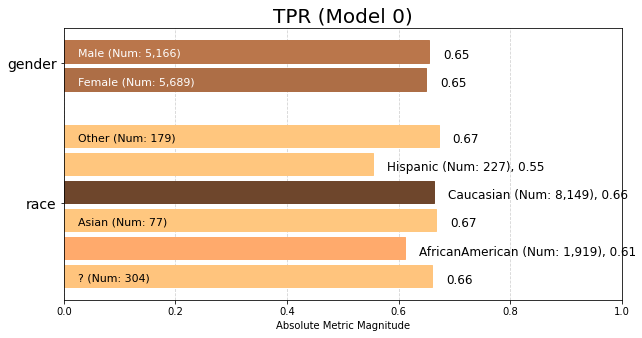

In [89]:
# Is there significant bias in your model for either race or gender?
tpr = aqp.plot_group_metric(clean_xtab, 'tpr')

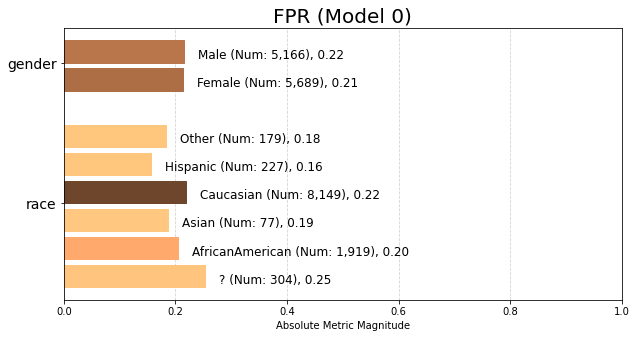

In [90]:
fpr = aqp.plot_group_metric(clean_xtab, 'fpr')

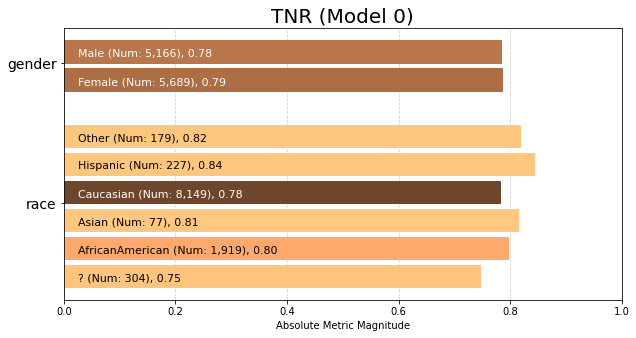

In [91]:
tnr = aqp.plot_group_metric(clean_xtab, 'tnr')

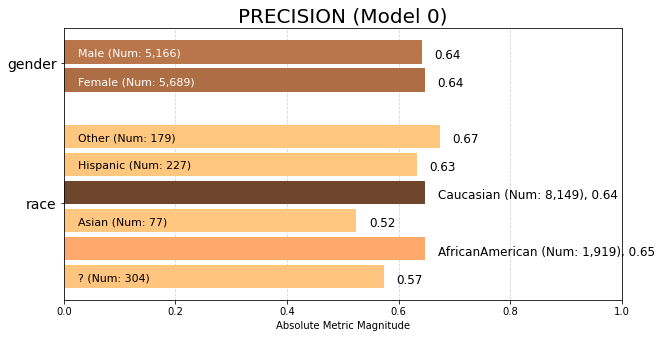

In [92]:
precision = aqp.plot_group_metric(clean_xtab, 'precision')

Bias analysis finds that Asian are more precisly identified than any other region. There are some un-identified regions have true classfication. African American and Caucasian(Reference) has almost same True classfied and false identified rate based on samples.

##Fairness Analysis Example - Relative to a Reference Group

Here we provided a visualization of the fairness evaluation for this reference group and analyze whether there is disparity.

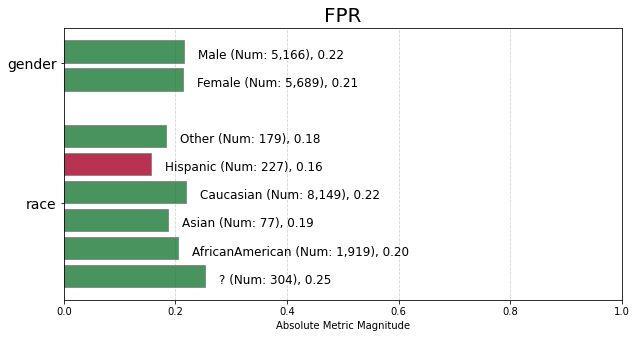

In [93]:
# Reference group fairness plot
fpr_fairness = aqp.plot_fairness_group(fdf, group_metric='fpr', title=True)

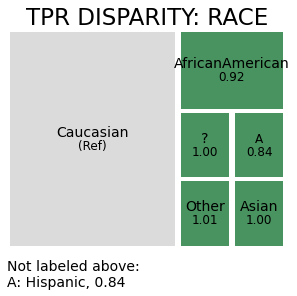

In [94]:
fpr_disparity_fairness = aqp.plot_fairness_disparity(fdf, group_metric='tpr', attribute_name='race')

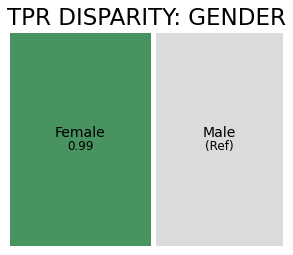

In [95]:
tpr_disparity_fairness = aqp.plot_fairness_disparity(fdf, group_metric='tpr', attribute_name='gender')